In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/zebra_vs_horse.zip"

In [11]:
import PIL
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
batch_size = 18
img_height = 70
img_width = 70

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/data/train",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 899 files belonging to 2 classes.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/data/valid",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 100 files belonging to 2 classes.


In [7]:
class_names = train_ds.class_names
num_classes =len(class_names)
print(class_names)

['horse', 'zebra']


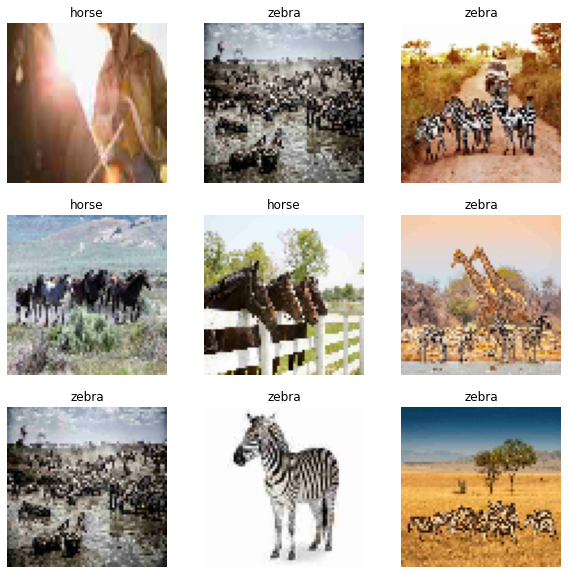

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [12]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(1000, activation='relu'),
  layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.01),activation
             ='linear')
])

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 70, 70, 3)         0         
_________________________________________________________________
rescaling (Rescaling)        (None, 70, 70, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 70, 70, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 35, 35, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 35, 35, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 64)       

In [14]:
model.compile(optimizer='adam',
              loss="hinge",
              metrics=['accuracy'])

In [15]:
checkpoint = ModelCheckpoint("model_animals_classification.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose = 1)

earlystop = EarlyStopping(monitor="val_loss",
                         min_delta=0,
                         patience=3,
                         verbose=1,
                         restore_best_weights=True)

callbacks = [earlystop, checkpoint]

In [16]:
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callbacks
)

Epoch 1/100
50/50 [==============================] - 10s 140ms/step - loss: 0.9129 - accuracy: 0.5806 - val_loss: 0.9167 - val_accuracy: 0.6400

Epoch 00001: val_loss improved from inf to 0.91668, saving model to model_animals_classification.h5
Epoch 2/100
50/50 [==============================] - 7s 130ms/step - loss: 0.5562 - accuracy: 0.7419 - val_loss: 0.5455 - val_accuracy: 0.8200

Epoch 00002: val_loss improved from 0.91668 to 0.54545, saving model to model_animals_classification.h5
Epoch 3/100
50/50 [==============================] - 7s 131ms/step - loss: 0.3777 - accuracy: 0.8254 - val_loss: 1.0521 - val_accuracy: 0.6700

Epoch 00003: val_loss did not improve from 0.54545
Epoch 4/100
50/50 [==============================] - 6s 129ms/step - loss: 0.4845 - accuracy: 0.7887 - val_loss: 1.3622 - val_accuracy: 0.6300

Epoch 00004: val_loss did not improve from 0.54545
Epoch 5/100
50/50 [==============================] - 7s 131ms/step - loss: 0.2395 - accuracy: 0.8988 - val_loss: 0.68

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

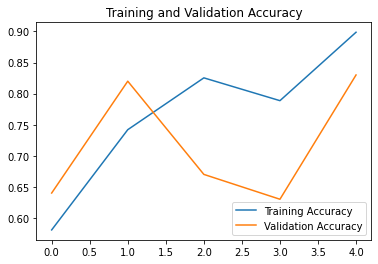

In [18]:
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

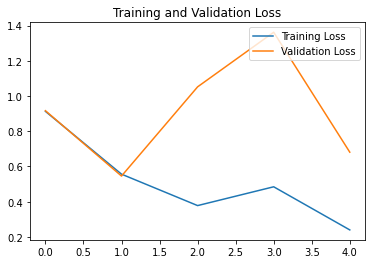

In [19]:
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Zebra


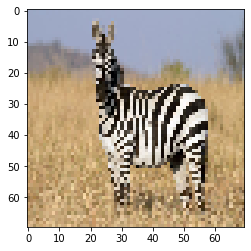

In [31]:
image_url = "https://cdn.mos.cms.futurecdn.net/HjFE8NKWuCmgfHCcndJ3rK-1200-80.jpg"
image_name = image_url.split("/")[-1]
image_path = tf.keras.utils.get_file(image_name, origin=image_url)

img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
if (predictions[0][0] > 1):
  print("Zebra")
else:
  print("Horse")

Horse


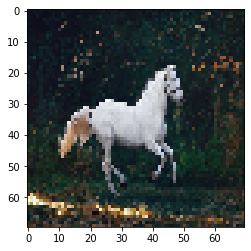

In [32]:
image_url = "https://images.unsplash.com/photo-1553284965-83fd3e82fa5a?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxleHBsb3JlLWZlZWR8Mnx8fGVufDB8fHx8&w=1000&q=80"
image_name = image_url.split("/")[-1]
image_path = tf.keras.utils.get_file(image_name, origin=image_url)

img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
if (predictions[0][0] > 1):
  print("Zebra")
else:
  print("Horse")

Horse


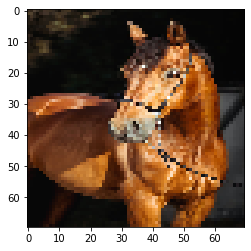

In [33]:
image_url = "https://images.unsplash.com/photo-1593179449458-e0d43d512551?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxleHBsb3JlLWZlZWR8MTF8fHxlbnwwfHx8fA%3D%3D&w=1000&q=80"
image_name = image_url.split("/")[-1]
image_path = tf.keras.utils.get_file(image_name, origin=image_url)

img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
if (predictions[0][0] > 1):
  print("Zebra")
else:
  print("Horse")

Zebra


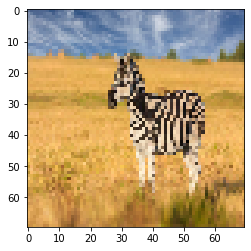

In [34]:
image_url = "https://images.ctfassets.net/cnu0m8re1exe/w4TS6ONjG71UXC3pkZDLc/5f162a88da4bebf9a9d29a867205b795/Zebra.jpg?fm=jpg&fl=progressive&w=660&h=433&fit=fill"
image_name = image_url.split("/")[-1]
image_path = tf.keras.utils.get_file(image_name, origin=image_url)

img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)

if (predictions[0][0] > 1):
  print("Zebra")
else:
  print("Horse")

49152/41483 [===================================] - 0s 7us/step
Zebra


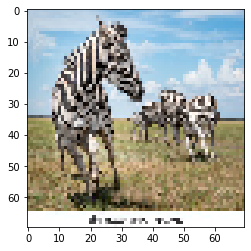

In [35]:
image_url = "https://image.shutterstock.com/image-photo/running-herd-zebras-national-biosphere-260nw-1771477040.jpg"
image_name = image_url.split("/")[-1]
image_path = tf.keras.utils.get_file(image_name, origin=image_url)

img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)

if (predictions[0][0] > 1):
  print("Zebra")
else:
  print("Horse")

114688/109613 [===============================] - 0s 0us/step
Horse


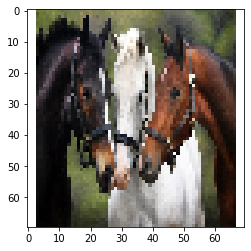

In [36]:
image_url = "https://i.ytimg.com/vi/zoJNvGOCH04/maxresdefault.jpg"
image_name = image_url.split("/")[-1]
image_path = tf.keras.utils.get_file(image_name, origin=image_url)

img = keras.preprocessing.image.load_img(
    image_path, target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)

if (predictions[0][0] > 1):
  print("Zebra")
else:
  print("Horse")

In [37]:
model.save("cnn_svm_classification.h5")